Chris Padgett

Greg Peters

CSCI 4800 Data Science

# Data Exploration

## Problem Statement and Background

Wouldn’t it be great if we could determine what movies are good before we see them? There isn’t a simple formula to follow to make a hit movie that everyone enjoys. Maybe a good movie comes from a good story created by movie writers, or maybe it’s from the actors playing the characters, or the director dictating the scene. It could even be a combination of all of these factors. This has led us to ask the question: Can we predict movie review ratings based on the director, cast or writers of a movie?

Gaining insight into the questions above is not only useful for the movie viewer, but also for the movie creators. Film is a multi billion dollar industry and is one of the most popular forms of entertainment today. Knowing if any of these data points has an impact on movie ratings could allow creators to make better decisions to make better movies for everyone to enjoy.

## The Data Sources

The data we have decided to use for the project is collected from the International Movie Database imdb.com. IMDB is widely used and updated consistently by many contributors giving us confidence that the data will be accurate.

The main data we are interested in for each movie is the critic review score, user review score, writers, directors, and full cast. While we are interested in these data points, other data was taken from the site and might be used as we see fit later in the project. For the list of movies to query from IMDB we used the-numbers.com which is a website that reports information on movie budgets. The list contains over 5,200 movie titles which even after data scrubbing should contain enough data for the machine learning as well as test data for prediction results. Since we scraped the data from IMDB, there will be some cleanup of the data needed up front. Most notably we scraped raw data from two different web pages for each movie in order to get the full cast and writers data needed for our predicion analysis.

The code we used to scrape IMDB uses a python library called Scrapy and is locaed in the *Data Collection* folder in our Github repository. Also located in the directory is an iPython notebook with the steps used to collect the data, as well as the raw data json object files.

## Data Joining and Cleaning

### Load and Parse Raw Data

Our raw data that was scraped from imdb.com comes from a main page for each movie as well as a child page that contains the full cast and writers data. As a result, we have data for each movie in two different json files. One file, *imdb_output.json* contains all of the movie data except for the full cast and writers which is stored in *imdb_people.json*. Luckily, IMDB has a unique key for each movie, so joining the data on the *movie_id* will be used and give us high confidence the data is joined correctly. Having this unique key movies also makes it so we know there are no missing or duplicate movies in the dataset.

We will be converting cast and writer people into unique *people_id*s since people can have the same name, but be different people. As with the *movie_id*, IMDB also stores people with a unique *people_id* making this task trivial. In addition, we will also be saving a dictionary linking people names to ids.

In [9]:
import os
import re
import csv
import json
import locale
import collections
import pickle

locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

def parse_price(price):
    # eg: u'$237,000,000' --> 237000000
    if not price:
        return 0
    return locale.atoi(re.sub('[^0-9,]', "", price))

def parse_duration(duration_string):
    if not duration_string:
        return 0

    if "min" in duration_string:
        if "h" in duration_string: # eg: "2h 49min"
            s = duration_string.split("h")
            hours = int(s[0])
            if len(s) > 1: # has minute number
                if "min" in s[1]:
                    minutes = int(s[1].strip().split("min")[0])
                else:
                    minutes = 0
            else:
                minutes = 0
            return 60 * hours + minutes
        else: # eg: "169 min"
            return int(duration_string.split('min')[0])
    else:
        if "h" in duration_string: # eg: "2h"
            return int(duration_string.split('h')[0].strip()) * 60
        else:
            return None

def load_unparsed_movie_metadata():
    try:
        with open("Data Collection/imdb_output.json", "r") as f:
            movies = json.load(f)
            return movies
    except:
        print("Cannot load the unparsed movie metadata file!")
        return None
    
def load_unparsed_movie_people():
    try:
        with open("Data Collection/imdb_people.json", "r") as f:
            movie_people = json.load(f)
            return movie_people
    except:
        print("Cannot load the unparsed movie people metadata file!")
        return None

def parse_genres(genres):
    if not genres:
        return None
    return "|".join([g.strip() for g in sorted(genres)])

def parse_plot_keywords(words):
    if not words:
        return None
    return "|".join([w.strip() for w in sorted(words)])

def parse_cast_info(cast):
    if not cast:
        return None
    return "|".join([c['name_id'].strip() for c in sorted(cast)])

def parse_writer_info(writers):
    if not writers:
        return None
    return "|".join([w['name_id'].strip() for w in sorted(writers)])

def parse_aspect_ratio(ratio_string):
    if not ratio_string:
        return None
    if ":" in ratio_string:
        return float(ratio_string.split(":")[0].strip())
    else:
        return float(re.search('[0-9,.]+', ratio_string).group())

def parse_one_movie_metadata(movie, movie_people):
    if not movie:
        return None

    parsed_movie = {}

    parsed_movie['movie_imdb_link'] = movie['movie_imdb_link']
    parsed_movie['imdb_id'] = movie['imdb_id']
    parsed_movie['movie_title'] = movie['movie_title'].encode('utf-8')
    parsed_movie['num_voted_users'] = movie['num_voted_users']
    parsed_movie['plot_keywords'] = parse_plot_keywords(movie['plot_keywords'])
    parsed_movie['num_user_for_reviews'] = movie['num_user_for_reviews']
    parsed_movie['language'] = None if movie['language'] is None or len(movie['language']) == 0 else movie['language'][0] # choose the first language
    parsed_movie['country'] = None if movie['country'] is None or len(movie['country']) == 0 else movie['country'][0] # choose 1st country
    parsed_movie['genres'] = parse_genres(movie['genres'])
    parsed_movie['color'] = None if movie['color'] is None or len(movie['color']) == 0 else movie['color'][0]
    parsed_movie['gross'] = None if movie['gross'] is None or len(movie['gross']) == 0 else parse_price(movie['gross'][0].strip())
    parsed_movie['content_rating'] = None if movie['content_rating'] is None or len(movie['content_rating']) == 0 else movie['content_rating'][0].strip()
    parsed_movie['budget'] = None if movie['budget'] is None or len(movie['budget']) == 0 else parse_price(movie['budget'][0].strip())
    parsed_movie['title_year'] = None if movie['title_year'] is None else int(movie['title_year'])
    parsed_movie['storyline'] = None if movie['storyline'] is None else movie['storyline'].strip().encode('utf-8')
    parsed_movie['user_review_score'] = None if movie['user_review_score'] is None or len(movie['user_review_score']) == 0 else float(movie['user_review_score'][0].strip())
    parsed_movie['critic_review_score'] = None if movie['critic_review_score'] is None or len(movie['critic_review_score']) == 0 else float(movie['critic_review_score'][0].strip())
    parsed_movie['aspect_ratio'] = parse_aspect_ratio(movie['aspect_ratio'])
    parsed_movie['num_critic_for_reviews'] = None if movie['num_critic_for_reviews'] is None else movie['num_critic_for_reviews']

    # parse movie duration
    duration = movie['duration']
    if not duration:
        parsed_movie['duration'] = None
    else:
        if len(duration) == 1:
            parsed_movie['duration'] = parse_duration(duration[0].strip())
        else:
            parsed_movie['duration'] = parse_duration(duration[-1].strip())
    
    # parse director info
    director_info = movie['director_info']
    if not director_info:
        parsed_movie['director_name_id'] = None
    else:
        parsed_movie['director_name_id'] = director_info['name_id'].encode('utf-8')
        
    # parse cast and writer info
    for movie_crew in movie_people:
        if parsed_movie['imdb_id'] == movie_crew['imdb_id']:
            parsed_movie['cast_info'] = parse_cast_info(movie_crew['cast_info'])
            parsed_movie['writer_info'] = parse_writer_info(movie_crew['writer_info'])
            break

    return parsed_movie

def parse_all_movies():
    movies = load_unparsed_movie_metadata()
    total_movies = len(movies)
    print("{} movie metadata were loaded!".format(total_movies))

    movie_people = load_unparsed_movie_people()
    total_movie_people = len(movie_people)
    print("{} movie people data were loaded!".format(total_movie_people))
    
    with open("Datasets/movie_metadata_all.csv", "w") as f:
        header_was_written = False
        for i, movie in enumerate(movies):
            parsed_movie = parse_one_movie_metadata(movie, movie_people)
            w = csv.DictWriter(f, parsed_movie.keys())
            if not header_was_written:
                w.writeheader()
                header_was_written = True

            w.writerow(parsed_movie)
            if (i+1) % 500 == 0 or i+1 == total_movies:
                print("Processed {} of {} movie metadata...".format(i+1, total_movies))
            
    print("Movie metadata processing complete!")

def create_people_name_dict():
    print("\nCreating Name_id to Name dictionary...")
    movie_people = load_unparsed_movie_people()
    
    people_id_dict = {}
    for movie in movie_people:
        for actor in movie['cast_info']:
            people_id_dict[actor['name_id']] = actor['actor_name'].replace('\n', '')
            
        for writer in movie['writer_info']:
            people_id_dict[writer['name_id']] = writer['writer_name'].replace('\n', '')
    
    print("Saving dictionary...")
    with open('Datasets/people_id_dictionary.pickle', 'wb') as handle:
        pickle.dump(people_id_dict, handle)
        
    print("Name_id to Name dictionary created!")
    
parse_all_movies()
create_people_name_dict()

5221 movie metadata were loaded!
5221 movie people data were loaded!
Processed 500 of 5221 movie metadata...
Processed 1000 of 5221 movie metadata...
Processed 1500 of 5221 movie metadata...
Processed 2000 of 5221 movie metadata...
Processed 2500 of 5221 movie metadata...
Processed 3000 of 5221 movie metadata...
Processed 3500 of 5221 movie metadata...
Processed 4000 of 5221 movie metadata...
Processed 4500 of 5221 movie metadata...
Processed 5000 of 5221 movie metadata...
Processed 5221 of 5221 movie metadata...
Movie metadata processing complete!

Creating Name_id to Name dictionary...
Saving dictionary...
Name_id to Name dictionary created!


### Data Cleaning

Now that we have parsed the data we will need to remove any movies that are missing data for the fields in which we are interested. Namely, we will need to remove any movie that is missing the cast info or writer info as they are the focus of the machine learning.

In [3]:
import pandas as pd

dirty_movie_data = pd.read_csv("Datasets/movie_metadata_all.csv")
required_fields = {'cast_info': 0, 'writer_info': 0}

def clean_movies(dirty_movie_data, required_fields):
    missing_data = []
    for i, movie in dirty_movie_data.iterrows():
        for req_field in required_fields:
            if pd.isnull(movie[req_field]):
                missing_data.append(movie['imdb_id'])
                required_fields[req_field] = required_fields[req_field] + 1
            
    for req_field in required_fields:
        print('Movies missing {}: {}'.format(req_field, required_fields[req_field]))
    
    missing_data = set(missing_data)
    print('Removing movies missing data...')
    return dirty_movie_data[~dirty_movie_data['imdb_id'].isin(missing_data)]

clean_movie_data = clean_movies(dirty_movie_data, required_fields)
print('Movies remaining: {}'.format(len(clean_movie_data)))

Movies missing cast_info: 28
Movies missing writer_info: 335
Removing movies missing data...
Movies remaining: 4886


### Create Critic and User Datasets

Since we are investigating two different ratings, critic and user, we will create two data sets; one for each. When making these datasets we will also need to remove movies that are missing the critic rating or user rating in the respective datasets. Also, if the number of contributed critic ratings or user ratings is too low we will also remove it. This is aimed at making the data more accurate by having a better sample size for the ratings.

In [6]:
import pickle

with open('Datasets/people_id_dictionary.pickle', 'rb') as handle:
    people_id_dict = pickle.load(handle)

min_required_critic_reviews = 10
min_required_user_reviews = 100

def create_smaller_people_dict(mov_dataset, people_dict):
    new_dict = {}
    for i, movie in mov_dataset.iterrows():
        for person_id in get_people_list(movie['cast_info']):
            new_dict[person_id] = people_dict[person_id]
        for person_id in get_people_list(movie['writer_info']):
            new_dict[person_id] = people_dict[person_id]
            
    return new_dict

def create_critic_dataset(clean_movie_data, min_required_critic_reviews):
    dirty_critic_data = {'critic_review_score': [], 'num_critic_for_reviews': []}
    for i, movie in clean_movie_data.iterrows():
        if pd.isnull(movie['critic_review_score']):
            dirty_critic_data['critic_review_score'].append(movie['imdb_id'])
            
        if pd.isnull(movie['num_critic_for_reviews']) or movie['num_critic_for_reviews'] < min_required_critic_reviews:
            dirty_critic_data['num_critic_for_reviews'].append(movie['imdb_id'])
            
    print('Critic Dataset - missing critic_review_score: {}'.format(len(dirty_critic_data['critic_review_score'])))
    print('Critic Dataset - not enough reviews (<{}): {}'.format(min_required_critic_reviews, len(dirty_critic_data['num_critic_for_reviews'])))
    
    critic_removal_list = set(dirty_critic_data['critic_review_score'] + dirty_critic_data['num_critic_for_reviews'])
    print('Removing movies from critic dataset...')
    return clean_movie_data[~clean_movie_data['imdb_id'].isin(critic_removal_list)]

def create_user_dataset(clean_movie_data, min_required_user_reviews):
    dirty_user_data = {'user_review_score': [], 'num_voted_users': []}
    for i, movie in clean_movie_data.iterrows():
        if pd.isnull(movie['user_review_score']):
            dirty_user_data['user_review_score'].append(movie['imdb_id'])
            
        if pd.isnull(movie['num_voted_users']) or movie['num_voted_users'] < min_required_user_reviews:
            dirty_user_data['num_voted_users'].append(movie['imdb_id'])
            
    print('User Dataset - missing user_review_score: {}'.format(len(dirty_user_data['user_review_score'])))
    print('User Dataset - not enough reviews (<{}): {}'.format(min_required_user_reviews, len(dirty_user_data['num_voted_users'])))
    
    user_removal_list = set(dirty_user_data['user_review_score'] + dirty_user_data['num_voted_users'])
    print('Removing movies from user dataset...')
    return clean_movie_data[~clean_movie_data['imdb_id'].isin(user_removal_list)]
    
full_critic_dataset = create_critic_dataset(clean_movie_data, min_required_critic_reviews)
print('Full Critic Dataset contains {} movies'.format(len(full_critic_dataset)))
full_critic_dataset.to_csv('Datasets/full_critic_dataset.csv')
critic_people_dict = create_smaller_people_dict(full_critic_dataset, people_id_dict)
with open('Datasets/critic_people_id_dictionary.pickle', 'wb') as handle:
        pickle.dump(critic_people_dict, handle)
print('Saved critic people dictionary containing {} people\n'.format(len(critic_people_dict)))

full_user_dataset = create_user_dataset(clean_movie_data, min_required_user_reviews)
print('Full User Dataset contains {} movies'.format(len(full_user_dataset)))
full_user_dataset.to_csv('Datasets/full_user_dataset.csv')
user_people_dict = create_smaller_people_dict(full_user_dataset, people_id_dict)
with open('Datasets/user_people_id_dictionary.pickle', 'wb') as handle:
        pickle.dump(user_people_dict, handle)
print('Saved user people dictionary containing {} people'.format(len(user_people_dict)))

Critic Dataset - missing critic_review_score: 1144
Critic Dataset - not enough reviews (<10): 303
Removing movies from critic dataset...
Full Critic Dataset contains 3717 movies
Saved critic people dictionary containing 133654 people

User Dataset - missing user_review_score: 39
User Dataset - not enough reviews (<100): 100
Removing movies from user dataset...
Full User Dataset contains 4786 movies
Saved user people dictionary containing 177774 people


### Divide Datasets into Learn and Test Data

We will be dividing the datasets into Learning and Test Datasets. The Learning Dataset will be used in the machine learning prediction algorithm and the Test Dataset will be used to test the prediction algorithm guess for accuracy. 90% of the full datasets will be used in the Learning Dataset and 10% for the Test Dataset.

In [4]:
def divide_dataset_learn_test(dataset_path, learn_path, test_path, learn_mod):
    ds = pd.read_csv(dataset_path)
    print('{} contains {} movies'.format(dataset_path, len(ds)))
    
    learn_ds = pd.DataFrame([row for i, row in ds.iterrows() if (i % learn_mod) != 0])
    test_ds = pd.DataFrame([row for i, row in ds.iterrows() if (i % learn_mod) == 0])
                    
    learn_ds.to_csv(learn_path)
    test_ds.to_csv(test_path)
            
learn_mod = 10
divide_dataset_learn_test('Datasets/full_critic_dataset.csv', 'Datasets/learn_critic_dataset.csv', 'Datasets/test_critic_dataset.csv', learn_mod)
learn_critic_dataset = pd.read_csv('Datasets/learn_critic_dataset.csv')
test_critic_dataset = pd.read_csv('Datasets/test_critic_dataset.csv')
print('Critic Learning Dataset size: {}'.format(len(learn_critic_dataset)))
print('Critic Testing Dataset size: {}\n'.format(len(test_critic_dataset)))

divide_dataset_learn_test('Datasets/full_user_dataset.csv', 'Datasets/learn_user_dataset.csv', 'Datasets/test_user_dataset.csv', learn_mod)
learn_user_dataset = pd.read_csv('Datasets/learn_user_dataset.csv')
test_user_dataset = pd.read_csv('Datasets/test_user_dataset.csv')
print('User Learning Dataset size: {}'.format(len(learn_user_dataset)))
print('User Testing Dataset size: {}'.format(len(test_user_dataset)))

Datasets/full_critic_dataset.csv contains 3717 movies
Critic Learning Dataset size: 3345
Critic Testing Dataset size: 372

Datasets/full_user_dataset.csv contains 4786 movies
User Learning Dataset size: 4307
User Testing Dataset size: 479


## Analysis Approach

Describe what analysis you are doing: This will probably comprise:
* Featurization: Explain how you generated features from the raw data, e.g., thresholding to produce binary features, binning, tf-idf, multinomial -> multiple binary features (one-hot encoding). Describe any value transformations you did, e.g., histogram normalization.
* Modeling: Which machine learning models did you try? Which do you plan to try in the future?
* Performance measurement: How will you evaluate your model and improve featurization, etc.

### Average Value Prediction
We thought it would be interesting to see if we could create our own algorithm for predicting rating values. In thinking about the data we have for this project, it seemed we could create a somewhat accurate prediction on movie ratings based on an average of ratings for actors and writers. The idea behind this is that an actor has good and bad movies in terms of ratings, and if they consistently make higher rated movies then it is more likely their contribution would help make the movie rating higher.

Notes:
* For prediction if a person has not been in a movie before, they do not affect the rating since there is nothing known about them

In [3]:
import csv
import pickle
import numpy as np
import pandas as pd

# Datasets for machine learning
learn_user_movdata = pd.read_csv('Datasets/learn_user_dataset.csv')
learn_critic_movdata = pd.read_csv('Datasets/learn_critic_dataset.csv')

# Datasets for testing predictions
test_user_movdata = pd.read_csv('Datasets/test_user_dataset.csv')
test_critic_movdata = pd.read_csv('Datasets/test_critic_dataset.csv')

# Load people id dictionary
with open('Datasets/people_id_dictionary.pickle', 'rb') as handle:
    people_id_dict = pickle.load(handle)
    
    
# Function to get a list of people from a people string
def get_people_list(people_string):
    return [name for name in people_string.split("|")]


# Function to get person name from person_id
def get_person_name(people_dict, name_id):
    return people_dict[name_id]
    
    
# Function to create Average Value Prediction dictionary
def train_avp(training_dataset, people_dict, review_tag, person_tag):
    avp_list_dict = {}
    avp_dict = {}
    for person in people_dict.iterkeys():
        avp_list_dict[person] = []
        avp_dict[person] = None
        
    for i, movie in training_dataset.iterrows():
        for person in get_people_list(movie[person_tag]):
            avp_list_dict[person].append(movie[review_tag])
    
    for person, rating_list in avp_list_dict.iteritems():
        avp_dict[person] = np.mean(rating_list) if rating_list is not None else None
        
    return avp_dict


# Create the prediction dictionaries
user_cast_avp_dict = train_avp(learn_user_movdata, people_id_dict, 'user_review_score', 'cast_info')
user_writer_avp_dict = train_avp(learn_user_movdata, people_id_dict, 'user_review_score', 'writer_info')
critic_cast_avp_dict = train_avp(learn_critic_movdata, people_id_dict, 'critic_review_score', 'cast_info')
critic_writer_avp_dict = train_avp(learn_critic_movdata, people_id_dict, 'critic_review_score', 'writer_info')

### Linear Regression
#### Notes on coding:
* From parsed data we make four tables (technically 4 for learning, and 4 for testing the predictions):
    * User reviews cast
        * each row is a movie
        * one column for movie_id
        * one column for user_review_score
        * one column per person_id, if the person is a cast member in the movie true, if not in the movie then false
    * User reviews writers
        * each row is a movie
        * one column for movie_id
        * one column for user_review_score
        * one column per person_id, if the person is a writer for the movie true, if not in the movie then false
    * Critic reviews cast
        * each row is a movie
        * one column for movie_id
        * one column for critic_review_score
        * one column per person_id, if the person is a cast member in the movie true, if not in the movie then false
    * Critic reviews writers
        * each row is a movie
        * one column for movie_id
        * one column for critic_review_score
        * one column per person_id, if the person is a writer for the movie true, if not in the movie then false
* Number of columns is really big, one column for each person in our person dictionary, so we write a row at a time for memory performance reasons, unfortunately this takes a long time for each movie
* Each column is needed for the lin regression, especially for testing where we could use any person as a writer or cast member
* Code in this section is primarily to show us changing the parsed data into a data format that the linear regression can use

In [8]:
import csv
import pickle
import numpy as np
import pandas as pd

# Datasets for machine learning
learn_user_movdata = pd.read_csv('Datasets/learn_user_dataset.csv')
learn_critic_movdata = pd.read_csv('Datasets/learn_critic_dataset.csv')

# Datasets for testing predictions
test_user_movdata = pd.read_csv('Datasets/test_user_dataset.csv')
test_critic_movdata = pd.read_csv('Datasets/test_critic_dataset.csv')

# Load user people_id dictionary
with open('Datasets/user_people_id_dictionary.pickle', 'rb') as handle:
    user_people_id_dict = pickle.load(handle)
    
# Load critic people_id dictionary
with open('Datasets/critic_people_id_dictionary.pickle', 'rb') as handle:
    critic_people_id_dict = pickle.load(handle)

# Function to get a column from a dataset
def get_col(colname, dataset):
    return [x[colname] for i, x in dataset.iterrows()]


# Function to get a list of people from a people string
def get_people_list(people_string):
    return [name for name in people_string.split("|")]


# Function to get person name from person_id
def get_person_name(people_dict, name_id):
    return people_dict[name_id]
    
    
# Function to create linear regression dataset
def create_lin_reg_data(mov_dataset, people_dict, review_tag, person_tag, out_dataset_file_path):
    print("    Writing dataset to '{}'".format(out_dataset_file_path))
    total_movies = len(mov_dataset)
    print("      {} people in this dataset".format(len(people_dict)))
    
    with open(out_dataset_file_path, "w") as f:
        movie_row = {}
        movie_row['imdb_id'] = 0
        movie_row[review_tag] = 0
        for person_id in people_dict.iterkeys():
            movie_row[person_id] = 0
            
        w = csv.DictWriter(f, movie_row.keys())
        w.writeheader()

        for i, movie in mov_dataset.iterrows():
            movie_row['imdb_id'] = movie['imdb_id']
            movie_row[review_tag] = movie[review_tag]

            movie_people = get_people_list(movie[person_tag])
            for person_id in people_dict.iterkeys():
                movie_row[person_id] = 1 if person_id in movie_people else 0

            w.writerow(movie_row)
            if (i+1) % 500 == 0 or i+1 == total_movies:
                print("      Processed {} of {} movies...".format(i+1, total_movies))
                
    print("    Finished writing file {}\n".format(out_dataset_file_path))


# Learn Linear Regression Datasets
print("Working on Learn Datasets")
print("  User Reviews")
learn_user_cast_data_file = 'Datasets/lin_reg/learn_user_cast_lin_reg.csv'
create_lin_reg_data(learn_user_movdata, user_people_id_dict, 'user_review_score', 'cast_info', learn_user_cast_data_file)

learn_user_writer_data_file = 'Datasets/lin_reg/learn_user_writer_lin_reg.csv'
create_lin_reg_data(learn_user_movdata, user_people_id_dict, 'user_review_score', 'writer_info', learn_user_writer_data_file)

print("  Critic Reviews")
learn_critic_cast_data_file = 'Datasets/lin_reg/learn_critic_cast_lin_reg.csv'
create_lin_reg_data(learn_critic_movdata, user_people_id_dict, 'critic_review_score', 'cast_info', learn_critic_cast_data_file)

learn_critic_writer_data_file = 'Datasets/lin_reg/learn_critic_writer_lin_reg.csv'
create_lin_reg_data(learn_critic_movdata, user_people_id_dict, 'critic_review_score', 'writer_info', learn_critic_writer_data_file)

# Test Linear Regression Datasets
print("Working on Test Datasets")
print("  User Reviews")
test_user_cast_data_file = 'Datasets/lin_reg/test_user_cast_lin_reg.csv'
create_lin_reg_data(test_user_movdata, critic_people_id_dict, 'user_review_score', 'cast_info', test_user_cast_data_file)

test_user_writer_data_file = 'Datasets/lin_reg/test_user_writer_lin_reg.csv'
create_lin_reg_data(test_user_movdata, critic_people_id_dict, 'user_review_score', 'writer_info', test_user_writer_data_file)

print("  Critic Reviews")
test_critic_cast_data_file = 'Datasets/lin_reg/test_critic_cast_lin_reg.csv'
create_lin_reg_data(test_critic_movdata, critic_people_id_dict, 'critic_review_score', 'cast_info', test_critic_cast_data_file)

test_critic_writer_data_file = 'Datasets/lin_reg/test_critic_writer_lin_reg.csv'
create_lin_reg_data(test_critic_movdata, critic_people_id_dict, 'critic_review_score', 'writer_info', test_critic_writer_data_file)

Working on Learn Datasets
  User Reviews
    Writing dataset to 'Datasets/lin_reg/learn_user_cast_lin_reg.csv'
      177774 people in this dataset


KeyboardInterrupt: 

## Preliminary Results

Summarize the results you have so far:
* Define suitable performance measures for your problem. Explain why they make sense, and what other measures you considered.
* Give the results. These might include accuracy scores, ROC plots and AUC, or precision/recall plots, or results of hypothesis tests.
* Describe any tuning that you did.
* Explain any hypothesis tests you did. Be explicit about the null and alternative hypothesis. Be very clear about the test you used and how you used it. Include all the experiment details (between/within-subjects, degrees-of-freedom, etc). Be frugal with tests. Do not try many tests and report the best results.
* Use graphics! Please use visual presentation whenever possible. The next best option is a table. Try to avoid "inlining" important results.

### Average Value Prediction

In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate percentage error
def calc_percent_error(experiment_result, actual_result):
    return abs((experiment_result - actual_result) / actual_result) * 100
    
    
# Function to predict rating of a movie
def predict_ratings(prediction_dict, test_movie_data, review_tag, person_tag):
    predicted_list = {}
    for i, movie in test_movie_data.iterrows():
        predicted_list[movie['imdb_id']] = []
        for person_id in get_people_list(movie[person_tag]):
            predicted_list[movie['imdb_id']].append(prediction_dict[person_id])
        
    predicted_movies = {}
    for movie_id, rating_list in predicted_list.iteritems():
        predicted_movies[movie_id] = np.nanmean(rating_list)
        
    return predicted_movies


# Function to calculate statistics for Average Value Prediction
def calc_AVP_stats(avp_prediction, test_movdata, review_tag, person_tag):
    movies_stats_dict = {}
    avp_stats_dict = {'person_tag': person_tag, 'review_tag': review_tag, 'movies_predicted': len(avp_prediction)}
    avp_stats_dict['person_tag_str'] = "user" if avp_stats_dict['review_tag'] is "user_review_score" else "critic"
    avp_stats_dict['review_tag_str'] = "cast" if avp_stats_dict['person_tag'] is "cast_info" else "writers"
    avp_stats_dict['review_scale_max'] = 10 if avp_stats_dict['review_tag'] is "user_review_score" else 100
    
    # Calculate differences
    for i, movie in test_movdata.iterrows():
        stats_dict = {}
        stats_dict['actual_review_score'] = movie[review_tag]
        stats_dict['predicted_review_score'] = avp_prediction[movie['imdb_id']]
        stats_dict['review_score_difference'] = abs(movie[review_tag] - avp_prediction[movie['imdb_id']])
        stats_dict['percent_error'] = calc_percent_error(stats_dict['predicted_review_score'], stats_dict['actual_review_score'])
        
        movies_stats_dict[movie['imdb_id']] = stats_dict
            
    avp_stats_dict['movies'] = movies_stats_dict
    
    # Create review difference list, and percent error list
    review_diff_list = []
    percent_error_list = []
    for movie_id, stats_dict in avp_stats_dict['movies'].iteritems():
        if not np.isnan(stats_dict['review_score_difference']):
            review_diff_list.append(stats_dict['review_score_difference'])
        if not np.isnan(stats_dict['percent_error']):
            percent_error_list.append(stats_dict['percent_error'])
            
    avp_stats_dict['review_score_difference_list'] = review_diff_list
    avp_stats_dict['average_error'] = np.mean(review_diff_list)
    avp_stats_dict['average_percent_error'] = np.mean(percent_error_list)
            
    return avp_stats_dict


# Function to display Average Value Prediction accuracy
def display_avp_accuracy(avp_stats_dict):
    plt.hist(avp_stats_dict['review_score_difference_list'])
    plt.title("Review Score Difference Histogram")
    plt.xlabel("Score Difference")
    plt.ylabel("Frequency")
    plt.show()
    
    print("Test Results based on {} test movies".format(avp_stats_dict['movies_predicted']))
    print("Average error is {} on an out of {} scale".format(avp_stats_dict['average_error'], avp_stats_dict['review_scale_max']))
    print("Percent error is {}".format(avp_stats_dict['average_percent_error']))

# Function to display all prediction results
def display_all_results(avp_prediction, test_movdata, review_tag, person_tag):
    avp_stats = calc_AVP_stats(avp_prediction, test_movdata, review_tag, person_tag)
    print("Displaying Average Value Prediction results for {} review scores based on {}".format(
        avp_stats['person_tag_str'], avp_stats['review_tag_str']))
    
    display_avp_accuracy(avp_stats)

    
# Get Average Value Predictions
predicted_user_cast_movies = predict_ratings(user_cast_avp_dict, test_user_movdata, 'user_review_score', 'cast_info')
predicted_user_writer_movies = predict_ratings(user_writer_avp_dict, test_user_movdata, 'user_review_score', 'writer_info')
predicted_critic_cast_movies = predict_ratings(critic_cast_avp_dict, test_critic_movdata, 'critic_review_score', 'cast_info')
predicted_critic_writer_movies = predict_ratings(critic_writer_avp_dict, test_critic_movdata, 'critic_review_score', 'writer_info')

#### User Review Scores based on Cast

Displaying Average Value Prediction results for user review scores based on cast


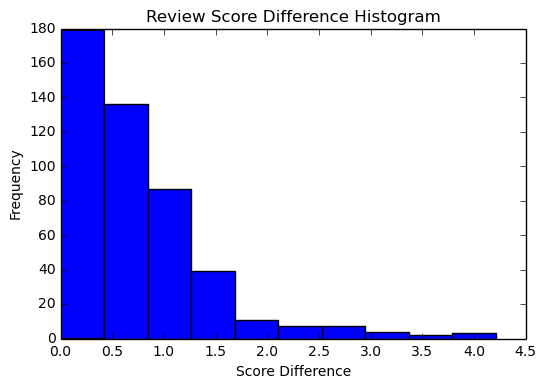

Test Results based on 478 test movies
Average error is 0.746631612788 on an out of 10 scale
Percent error is 13.9141019906


In [6]:
display_all_results(predicted_user_cast_movies, test_user_movdata, 'user_review_score', 'cast_info')

#### User Review Scores based on Writers

Displaying Average Value Prediction results for user review scores based on writers


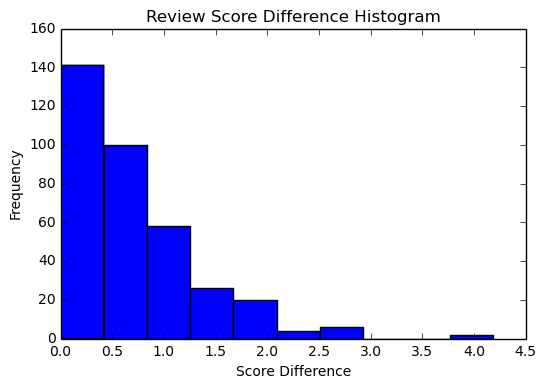

Test Results based on 478 test movies
Average error is 0.715606402333 on an out of 10 scale
Percent error is 12.1144043356


In [7]:
display_all_results(predicted_user_writer_movies, test_user_movdata, 'user_review_score', 'writer_info')

#### Critic Review Scores based on Cast

Displaying Average Value Prediction results for critic review scores based on cast


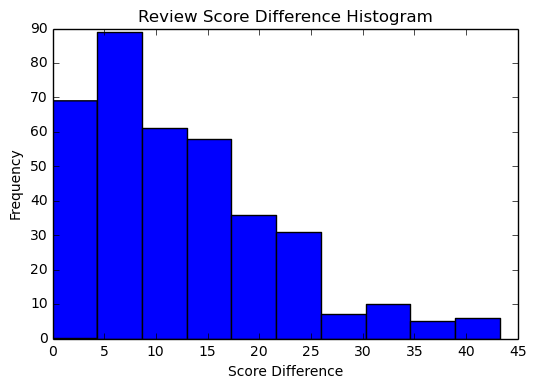

Test Results based on 372 test movies
Average error is 12.3554012645 on an out of 100 scale
Percent error is 30.0122245989


In [8]:
display_all_results(predicted_critic_cast_movies, test_critic_movdata, 'critic_review_score', 'cast_info')

#### Critic Review Scores based on Writers

Displaying Average Value Prediction results for critic review scores based on writers


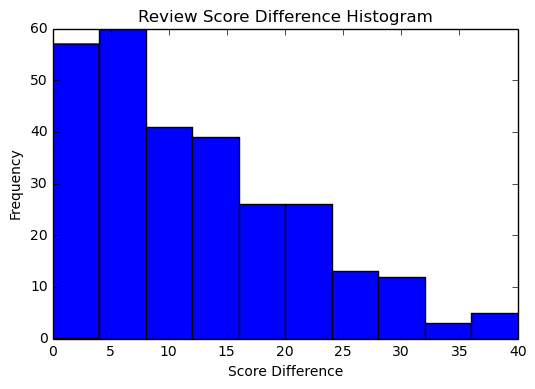

Test Results based on 372 test movies
Average error is 12.0792032002 on an out of 100 scale
Percent error is 25.520688125


In [9]:
display_all_results(predicted_critic_writer_movies, test_critic_movdata, 'critic_review_score', 'writer_info')

### Linear Regression
* Currently we are in the process of converting parsed actor ids into a true false table representing if the person was in the movie. The user review score dataset has 177,774 people across all movies meaning our tables have a large number of columns. This is making the creating of these datasets for use in the linear regresson learning model take a very long time.

## Final Analysis, any Obstacles

Describe the final analysis you plan to do:
* Scale: how much data will you use?
* Model complexity: What complexity of models will you use, this is relevant for models like clustering, factor models, Random Forests, etc.
* What tools will you use?
* Estimate of processing time? You should be able to form an estimate of how much time you need on your chosen tools.

and outline any obstacles you foresee.

### Linear Regression
In a 36 hour period, only about 300 of 5000 movies had been parsed meaning we didn't have enough time to create the learning and test data tables for this assignment. We will continue to find a solution to this issue.